In [79]:
import networkx as nx #pip install networkx
from datetime import datetime
from time import time
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords  #pip install nltk
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
from nltk.stem.porter import PorterStemmer
import string
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from gensim.models import word2vec  #pip install word2vec
from wordcloud import WordCloud  #pip install wordcloud
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import NMF, LatentDirichletAllocation
from textblob import TextBlob  #Sentiment Analysis - pip install textblob
from sklearn.decomposition import TruncatedSVD, NMF
import matplotlib.patches as mpatches
import matplotlib
path_to_csv = '../../../cs82_advanced_machine_learning_data/HW2/papers.csv'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khan_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
df_allPlays = pd.read_csv('Shakespeare_data.csv')
print(allPlays.shape)
df_allPlays.head()

(111396, 6)


Dataline      Play  PlayerLinenumber ActSceneLine         Player  \
0         1  Henry IV               NaN          NaN            NaN   
1         2  Henry IV               NaN          NaN            NaN   
2         3  Henry IV               NaN          NaN            NaN   
3         4  Henry IV               1.0        1.1.1  KING HENRY IV   
4         5  Henry IV               1.0        1.1.2  KING HENRY IV   

                                          PlayerLine  
0                                              ACT I  
1                       SCENE I. London. The palace.  
2  Enter KING HENRY, LORD JOHN OF LANCASTER, the ...  
3             So shaken as we are, so wan with care,  
4         Find we a time for frighted peace to pant,

In [59]:
df_allPlays.isna().sum()

Dataline               0
Play                   0
PlayerLinenumber       3
ActSceneLine        6243
Player                 7
PlayerLine             0
dtype: int64

In [61]:
df_allPlays[df_allPlays.isnull().any(axis=1)].head()

Dataline      Play  PlayerLinenumber ActSceneLine        Player  \
0           1  Henry IV               NaN          NaN           NaN   
1           2  Henry IV               NaN          NaN           NaN   
2           3  Henry IV               NaN          NaN           NaN   
111       112  Henry IV              10.0          NaN  WESTMORELAND   
112       113  Henry IV              10.0          NaN  WESTMORELAND   

                                            PlayerLine  
0                                                ACT I  
1                         SCENE I. London. The palace.  
2    Enter KING HENRY, LORD JOHN OF LANCASTER, the ...  
111                                             Exeunt  
112    SCENE II. London. An apartment of the Prince's.

In [62]:
df_allPlays.ActSceneLine.isnull().groupby([df_allPlays['Play']]).sum()

Play
A Comedy of Errors           88.0
A Midsummer nights dream    138.0
A Winters Tale              125.0
Alls well that ends well    158.0
Antony and Cleopatra        297.0
As you like it              145.0
Coriolanus                  224.0
Cymbeline                   201.0
Hamlet                      224.0
Henry IV                    161.0
Henry V                     162.0
Henry VI Part 1             206.0
Henry VI Part 2             204.0
Henry VI Part 3             199.0
Henry VIII                  140.0
Julius Caesar               174.0
King John                   117.0
King Lear                   266.0
Loves Labours Lost          108.0
Measure for measure         158.0
Merchant of Venice          137.0
Merry Wives of Windsor      217.0
Much Ado about nothing      120.0
Othello                     199.0
Pericles                    169.0
Richard II                  137.0
Richard III                 236.0
Romeo and Juliet            217.0
Taming of the Shrew         169.0
The Tempe

In [77]:
class RemoveAllNans (TransformerMixin, BaseEstimator):
    def __init__(self, prints = False):
        self.prints = prints
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X.dropna()
    
    
class split_act_scene_line (TransformerMixin, BaseEstimator):
    def __init__(self, prints = False):
        self.prints = prints
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        X[['Act','Scene','Line']] = X['ActSceneLine'].str.split('.', expand=True).apply(pd.to_numeric)
        return X
    
class group_data(TransformerMixin, BaseEstimator):
    def __init__(self, grouping = "Act",  prints = False):
        self.prints = prints
        self.grouping = grouping
        print(self.grouping)
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        if self.grouping == "Play" : 
                group_by = ["Play"]
        elif self.grouping == "Act" : 
                group_by = ["Play", "Act"]
        elif self.grouping == "Scene":
                group_by = ["Play", "Act", "Scene"]
                
        lines = X.groupby(group_by)["PlayerLine"].sum().reset_index()["PlayerLine"]
        players = X.groupby(group_by)["Player"].unique().reset_index()
        X_new = pd.concat([players, lines], axis=1)
        return X_new

In [87]:
allplays_pipeline = Pipeline([
    ('romove_na', RemoveAllNans()),
    ('split_act_scene_line', split_act_scene_line()),
    ('group_data', group_data(grouping="Scene"))
])

df_PlayData = allplays_pipeline.fit_transform(df_allPlays)

df_PlayData.head(200)

Scene


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Play  Act  Scene  \
0          A Comedy of Errors    1      1   
1          A Comedy of Errors    1      2   
2          A Comedy of Errors    2      1   
3          A Comedy of Errors    2      2   
4          A Comedy of Errors    3      1   
5          A Comedy of Errors    3      2   
6          A Comedy of Errors    4      1   
7          A Comedy of Errors    4      2   
8          A Comedy of Errors    4      3   
9          A Comedy of Errors    4      4   
10         A Comedy of Errors    5      1   
11   A Midsummer nights dream    1      1   
12   A Midsummer nights dream    1      2   
13   A Midsummer nights dream    2      1   
14   A Midsummer nights dream    2      2   
15   A Midsummer nights dream    3      1   
16   A Midsummer nights dream    3      2   
17   A Midsummer nights dream    4      1   
18   A Midsummer nights dream    4      2   
19   A Midsummer nights dream    5      1   
20             A Winters Tale    1      1   
21             A Winters Tale    1      2   
22             A Winters Tale    2      1   
23             A Winters Tale    2      2   
24             A Winters Tale    2      3   
25             A Winters Tale    3      1   
26             A Winters Tale    3      2   
27             A Winters Tale    3      3   
28             A Winters Tale    4      2   
29             A Winters Tale    4      3   
..                        ...  ...    ...   
170                 Cymbeline    4      4   
171                 Cymbeline    5      1   
172                 Cymbeline    5      2   
173                 Cymbeline    5      3   
174                 Cymbeline    5      4   
175                 Cymbeline    5      5   
176                    Hamlet    1      1   
177                    Hamlet    1      2   
178                    Hamlet    1      3   
179                    Hamlet    1      4   
180                    Hamlet    1      5   
181                    Hamlet    2      1   
182                    Hamlet    2      2   
183                    Hamlet    3      1   
184                    Hamlet    3      2   
185                    Hamlet    3      3   
186                    Hamlet    3      4   
187                    Hamlet    4      1   
188                    Hamlet    4      2   
189                    Hamlet    4      3   
190                    Hamlet    4      4   
191                    Hamlet    4      5   
192                    Hamlet    4      6   
193                    Hamlet    4      7   
194                    Hamlet    5      1   
195                    Hamlet    5      2   
196                  Henry IV    1      1   
197                  Henry IV    1      2   
198                  Henry IV    1      3   
199                  Henry IV    2      1   

                                                Player  \
0                       [AEGEON, DUKE SOLINUS, Gaoler]   
1    [First Merchant, OF SYRACUSE, DROMIO OF SYRACU...   
2                [ADRIANA, LUCIANA, DROMIO OF EPHESUS]   
3    [LUCIANA, OF SYRACUSE, DROMIO OF SYRACUSE, ADR...   
4    [LUCIANA, OF EPHESUS, DROMIO OF EPHESUS, BALTH...   
5    [LUCIANA, OF SYRACUSE, DROMIO OF SYRACUSE, ANT...   
6    [Second Merchant, ANGELO, Officer, OF EPHESUS,...   
7               [ADRIANA, LUCIANA, DROMIO OF SYRACUSE]   
8    [ADRIANA, OF SYRACUSE, DROMIO OF SYRACUSE, Cou...   
9    [Courtezan, OF EPHESUS, DROMIO OF EPHESUS, Off...   
10   [ANGELO, Second Merchant, OF SYRACUSE, ADRIANA...   
11   [THESEUS, HIPPOLYTA, EGEUS, HERMIA, DEMETRIUS,...   
12   [QUINCE, BOTTOM, FLUTE, STARVELING, SNOUT, SNU...   
13   [PUCK, Fairy, OBERON, TITANIA, DEMETRIUS, HELENA]   
14   [TITANIA, Fairy, OBERON, LYSANDER, HERMIA, PUC...   
15   [BOTTOM, QUINCE, SNOUT, STARVELING, PUCK, FLUT...   
16   [OBERON, PUCK, DEMETRIUS, HERMIA, LYSANDER, HE...   
17   [PUCK, TITANIA, BOTTOM, PEASEBLOSSOM, COBWEB, ...   
18           [QUINCE, STARVELING, FLUTE, SNUG, BOTTOM]   
19   [HIPPOLYTA, THESEUS, LYSANDER, PHILOSTRATE, Pr...   
20              

In [74]:
print(df_PlayData.isna().sum())
print(df_PlayData.dtypes)
print(df_PlayData.shape)

Play          0
Act           0
Player        0
PlayerLine    0
dtype: int64
Play          object
Act            int64
Player        object
PlayerLine    object
dtype: object
(181, 4)


Name: 
Type: Graph
Number of nodes: 971
Number of edges: 1328
Average degree:   2.7353


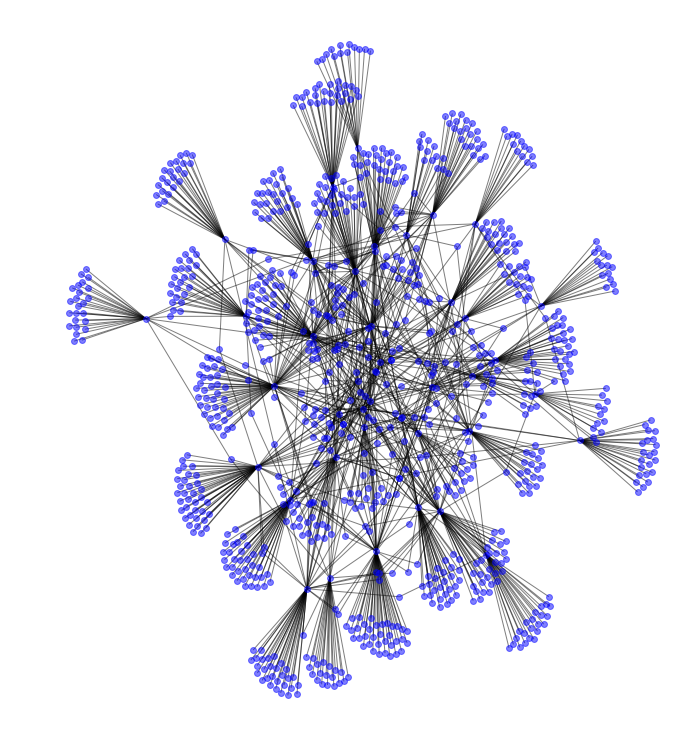

In [93]:
Graphx= nx.Graph()
Graphx = nx.from_pandas_edgelist(df_allPlays,source='Play',target='Player')
print (nx.info(Graphx))
plt.figure(figsize=(9,10)) 
nx.draw(Graphx,alpha=0.5, node_color="blue",with_labels=False,node_size=35)
plt.show()